In [1]:
import os

if not os.path.exists("VoxCeleb_gender"):
    !pip install gdown pydub librosa
    !gdown https://drive.google.com/uc?id=1V3lNnSDv71AJYIj71V4_xD0ir0DrXxEV
    !tar -xf VoxCeleb_gender.zip #!tar -xf VoxCeleb_gender.zip
    !del VoxCeleb_gender.zip     #!del

else:
    print("Dataset already downloaded.")

Dataset already downloaded.


In [2]:
import librosa
import scipy.signal as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def extract_mfcc(file_path, n_mfcc=12, win_length=320, hop_length=160):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    if sr != 16000:
        wave = librosa.resample(wave, sr, 16000)
    mfcc = librosa.feature.mfcc(y=wave, sr=16000, n_mfcc=n_mfcc, window=ss.windows.hamming, win_length=win_length, hop_length=hop_length)
    return mfcc

# Build data in memory

In [3]:
mfcc_coeff_amount = 12
window_length = int(16000*0.02)

In [4]:
arr = []
if not os.path.exists(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl"):

    aux = []

    for (dirpath, dirnames, filenames) in os.walk("VoxCeleb_gender"):
        for filename in filenames:
            if filename.endswith(".wav"):
                filepath = dirpath + "/" + filename
                aux.append({"file": filepath, "gender": dirpath.split("/")[-1]})

    df = pd.DataFrame(aux)

    df["mfcc"] = pd.Series(name="mfcc", dtype=object)

    for i in range(len(df)):
        mfcc_coeffs = extract_mfcc(df.loc[i, "file"], n_mfcc=mfcc_coeff_amount, win_length=window_length)
        for i, coeffs in enumerate(mfcc_coeffs):
            if np.linalg.norm(coeffs) < 1:
                mfcc_coeffs.pop(i)
        arr.append(mfcc_coeffs)
    df["mfcc"] = arr
    df.to_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}")
else:
    print("File Found")
    df = pd.read_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")


num_males = len(df.loc[df.gender == "males"] )           
num_females = len(df.loc[df.gender == "females"] )              

File Found


In [5]:
print("Number of males: ", num_males)
print("Number of females: ", num_females)

Number of males:  3682
Number of females:  2311


In [6]:
display(df)

,file,gender,mfcc
0,VoxCeleb_gender/males/255.wav,males,"[[-266.89233, -288.64322, -288.0051, -277.8506..."
1,VoxCeleb_gender/males/1908.wav,males,"[[-362.22406, -338.4697, -335.41837, -333.9136..."
2,VoxCeleb_gender/males/2965.wav,males,"[[-407.10593, -375.89368, -386.202, -388.78607..."
3,VoxCeleb_gender/males/2733.wav,males,"[[-299.1009, -257.6437, -261.46454, -229.911, ..."
4,VoxCeleb_gender/males/3091.wav,males,"[[-259.80472, -288.65842, -285.53375, -291.276..."
...,...,...,...
5988,VoxCeleb_gender/females/489.wav,females,"[[-439.62015, -451.93927, -449.33908, -452.043..."
5989,VoxCeleb_gender/females/941.wav,females,"[[-327.78085, -321.0226, -342.2135, -330.92526..."
5990,VoxCeleb_gender/females/63.wav,females,"[[-408.27185, -391.82303, -360.8797, -308.7707..."
5991,VoxCeleb_gender/females/1820.wav,females,"[[-365.03598, -326.88446, -337.80292, -328.621..."


# EDA

In [7]:
# Get the mean mfcc coefficients for each class
mean_mfcc_males = 0
mean_mfcc_females = 0


for person in df.iterrows():
    for i in range(len(person[1]["mfcc"])//mfcc_coeff_amount):
        if person[1]["gender"] == "males":
            mean_mfcc_males = np.mean(np.array(person[1]["mfcc"]), axis=1)/num_males
        else:
            mean_mfcc_females = np.mean(person[1]["mfcc"], axis=1)/num_females

display(mean_mfcc_males)
display(mean_mfcc_females)

array([-0.11972281,  0.02990563, -0.01197125,  0.00156714, -0.0089404 ,
       -0.00567426, -0.00416346, -0.00176591, -0.00151322, -0.00049492,
       -0.00278864,  0.00304949], dtype=float32)

array([-0.1156978 ,  0.03775504, -0.00754318,  0.00508091, -0.01344521,
       -0.01013145, -0.00357516, -0.00078147,  0.00039397,  0.00086333,
       -0.0044957 , -0.00069347], dtype=float32)

In [8]:
score_males = []
score_females = []

for i in range(1000):
    score_males.append(np.sum(df.mfcc[df.gender=="males"][i], axis=1) @ mean_mfcc_males)
    score_females.append(np.sum(df.mfcc[df.gender=="females"][i + num_males], axis=1) @ mean_mfcc_males)


(array([484., 349.,  97.,  36.,  19.,   3.,   4.,   2.,   1.,   1.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.]),
 array([  6138.01416016,  24842.1796875 ,  43546.34375   ,  62250.5078125 ,
         80954.671875  ,  99658.8359375 , 118363.        , 137067.171875  ,
        155771.328125  , 174475.5       , 193179.65625   , 211883.828125  ,
        230588.        , 249292.15625   , 267996.3125    , 286700.5       ,
        305404.65625   , 324108.8125    , 342812.96875   , 361517.15625   ,
        380221.3125    ]),
 <BarContainer object of 20 artists>)

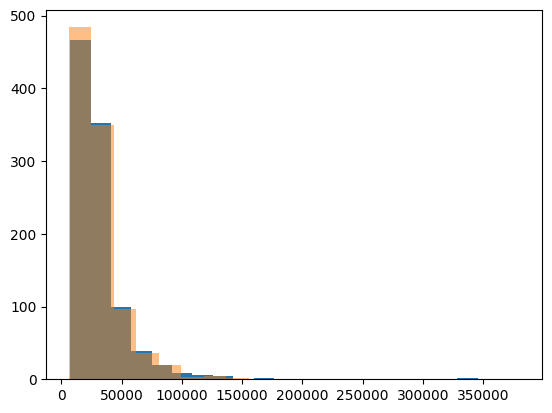

In [9]:
plt.hist(score_males, bins=20)
plt.hist(score_females, bins=20, alpha=0.5)

# GMM Model

In [32]:
np.concatenate(df.mfcc[df.gender=="males"].to_numpy()[::1000], axis=1).T.shape

(2057, 12)

In [65]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

gmm_male = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)
gmm_female = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)

gmm_male.fit(np.concatenate(df.mfcc[df.gender=="males"].to_numpy(), axis=1).T)
gmm_female.fit(np.concatenate(df.mfcc[df.gender=="females"].to_numpy(), axis=1).T)

In [11]:
import pickle

with open('gmm_male.pkl','wb') as f:
    pickle.dump(gmm_male,f)

with open('gmm_female.pkl','wb') as f:
    pickle.dump(gmm_female,f)

In [61]:
scores_fvsm = gmm_male.score_samples(np.concatenate(df.mfcc[df.gender=="males"].to_numpy()[::100], axis=1).T)
scores_mvsm = gmm_male.score_samples(np.concatenate(df.mfcc[df.gender=="females"].to_numpy()[::100], axis=1).T)

In [62]:
scores_mvsm

array([-51.91826049, -61.11946087, -55.55514214, ...,  -3.52810312,
        -3.52810312,  -3.52810312])

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 7.000e+00,
        7.000e+00, 1.100e+01, 9.000e+00, 2.000e+01, 2.900e+01, 4.100e+01,
        4.000e+01, 5.400e+01, 6.200e+01, 8.800e+01, 9.900e+01, 1.120e+02,
        1.560e+02, 1.330e+02, 1.820e+02, 2.220e+02, 2.730e+02, 3.880e+02,
        5.210e+02, 6.160e+02, 7.190e+02, 8.960e+02, 9.440e+02, 1.094e+03,
        1.316e+03, 1.448e+03, 1.447e+03, 1.433e+03, 1.266e+03, 9.270e+02,
        6.070e+02, 2.890e+02, 1.190e+02, 1.600e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

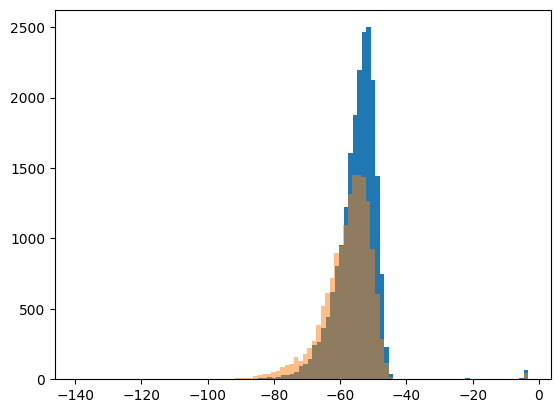

In [63]:
plt.hist(scores_fvsm, bins=100)
plt.hist(scores_mvsm, bins=100,alpha=0.5)

In [12]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "covariance_type": ["full", "tied", "diag", "spherical"],
}

grid_search = GridSearchCV(GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(np.concatenate(df.mfcc[df.gender=="males"].to_numpy()[::1000], axis=1))

/home/gullino18/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gullino18/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/mixture/_gaussian_mixture.py", line 338, in _compute_precision_cholesky
    cov_chol = linalg.cholesky(covariances, lower=True)
  File "/home/gullino18/.pyenv/versions/3.9.16/lib/python3.9/site-packages/scipy/linalg/_decomp_cholesky.py", line 88, in cholesky
    c, lower = _cholesky(a, lower=lower, overwrite_a=overwrite_a, clean=True,
  File "/home/gullino18/.pyenv/version

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical']},
             scoring=<function gmm_bic_score at 0x7f65196d9f70>)